# Home Credit Ad Hoc Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, randint, uniform
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from IPython.display import display
import warnings
import pickle
import gc

%load_ext autotime
# %unload_ext autotime

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
gc.enable()
np.random.seed(0)

path = "/Users/dsaxton/home_credit_default/"

#### Application table

In [ ]:
application_test = pd.read_csv(path + "application_test.csv")

In [ ]:
application_train = pd.read_csv(path + "application_train.csv")

#### Previous application and behavioral tables

In [ ]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")
bureau = pd.read_csv(path + "bureau.csv")
credit_card = pd.read_csv(path + "credit_card_balance.csv")
installments = pd.read_csv(path + "installments_payments.csv")
pos_cash = pd.read_csv(path + "POS_CASH_balance.csv")
previous_application = pd.read_csv(path + "previous_application.csv")

#### Aggregate tables

In [ ]:
bureau_agg = pd.read_csv(path + "bureau_agg.csv")

In [ ]:
credit_card_agg = pd.read_csv(path + "credit_card_agg.csv")

#### Joined table

In [ ]:
df = pd.read_csv(path + "preprocessed_train.csv")

# Feature construction sand box

In [2]:
def quick_model(X, y, usecols, n_estimators, num_leaves):
    clf = lgb.LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves)
    clf.fit(X[cols], y)
    var_imp = pd.DataFrame({"Feature": df[cols].columns, "Importance": clf.feature_importances_})[["Feature", "Importance"]].sort_values("Importance", ascending=False)
    auc = round(cross_val_score(estimator=clf, X=X[cols], y=y, scoring="roc_auc").mean(), 4)
    
    return {"var_imp": var_imp, "auc": auc}

time: 5.13 ms


# Bureau

In [3]:
def bureau_agg_func(g):
    mask6 = g["DAYS_CREDIT_UPDATE"] >= -180
    mask12 = g["DAYS_CREDIT_UPDATE"] >= -360
    mask24 = g["DAYS_CREDIT_UPDATE"] >= -720
    active = g["CREDIT_ACTIVE"] == "Active"
    
    d = {"MAX_BUREAU_UTILIZATION_6M": np.nanmax((g["AMT_CREDIT_SUM_DEBT"] / g["AMT_CREDIT_SUM"]).where(mask6)), 
        "MAX_BUREAU_UTILIZATION_12M": np.nanmax((g["AMT_CREDIT_SUM_DEBT"] / g["AMT_CREDIT_SUM"]).where(mask12)), 
        "COUNT_ACTIVE_6M": np.nansum((g["CREDIT_ACTIVE"] == "Active").where(mask6)), 
        "COUNT_ACTIVE_12M": np.nansum((g["CREDIT_ACTIVE"] == "Active").where(mask12)), 
        "COUNT_ACTIVE_24M": np.nansum((g["CREDIT_ACTIVE"] == "Active").where(mask24)), 
        "DAYS_REMAINING_ACTIVE": np.nansum(g["DAYS_CREDIT_ENDDATE"].where(active)), 
        "MAX_CREDIT_DAY_OVERDUE_6M": np.nanmax(g["CREDIT_DAY_OVERDUE"].where(mask6)), 
        "MAX_CREDIT_DAY_OVERDUE_DIFF_6M_12M": np.nanmax(g["CREDIT_DAY_OVERDUE"].where(mask6)) - np.nanmax(g["CREDIT_DAY_OVERDUE"].where(mask6 ^ mask12)), 
        "BUREAU_UTILIZATION_DIFF_6M_12M": np.nanmean((g["AMT_CREDIT_SUM_DEBT"] / g["AMT_CREDIT_SUM_LIMIT"]).where(active & mask6)) - np.nanmean((g["AMT_CREDIT_SUM_DEBT"] / g["AMT_CREDIT_SUM_LIMIT"]).where(active & (mask6 ^ mask12))), 
        "BUREAU_UTILIZATION_DIFF_12M_24M": np.nanmean((g["AMT_CREDIT_SUM_DEBT"] / g["AMT_CREDIT_SUM_LIMIT"]).where(active & mask12)) - np.nanmean((g["AMT_CREDIT_SUM_DEBT"] / g["AMT_CREDIT_SUM_LIMIT"]).where(active & (mask6 ^ mask24))), 
        "BUREAU_SUM_DEBT_DIFF_6M_12M": np.nansum(g["AMT_CREDIT_SUM_DEBT"].where(active & mask6)) - np.nansum(g["AMT_CREDIT_SUM_DEBT"].where(active & (mask6 ^ mask12))),
        "BUREAU_SUM_DEBT_DIFF_12M_24M": np.nansum(g["AMT_CREDIT_SUM_DEBT"].where(active & mask6)) - np.nansum(g["AMT_CREDIT_SUM_DEBT"].where(active & (mask6 ^ mask12))),         
        "MAX_CNT_CREDIT_PROLONG": np.nanmax(g["CNT_CREDIT_PROLONG"])}
    
    return pd.Series(d)

time: 10.4 ms


#### Process data and join

In [4]:
df = pd.read_csv(path + "application_train.csv")
df = df.sample(10000)

bureau = pd.read_csv(path + "bureau.csv")
bureau = bureau[bureau["SK_ID_CURR"].isin(df["SK_ID_CURR"])]
bureau_balance_agg = pd.read_csv(path + "bureau_balance_agg.csv")

bureau_balance_agg = bureau_balance_agg[bureau_balance_agg["SK_ID_BUREAU"].isin(bureau["SK_ID_BUREAU"])]
bureau_joined = pd.merge(bureau, bureau_balance_agg, how="left", on="SK_ID_BUREAU")
bureau_agg = bureau_joined.groupby("SK_ID_CURR").apply(bureau_agg_func).reset_index()

df = pd.merge(df, bureau_agg, how="left", on="SK_ID_CURR")

time: 1min 53s


#### Fit quick model

In [5]:
cols = ["MAX_BUREAU_UTILIZATION_6M", 
    "MAX_BUREAU_UTILIZATION_12M", 
    "COUNT_ACTIVE_6M", 
    "COUNT_ACTIVE_12M", 
    "COUNT_ACTIVE_24M", 
    "DAYS_REMAINING_ACTIVE", 
    "MAX_CREDIT_DAY_OVERDUE_6M", 
    "MAX_CREDIT_DAY_OVERDUE_DIFF_6M_12M", 
    "BUREAU_UTILIZATION_DIFF_6M_12M", 
    "BUREAU_UTILIZATION_DIFF_12M_24M", 
    "BUREAU_SUM_DEBT_DIFF_6M_12M", 
    "BUREAU_SUM_DEBT_DIFF_12M_24M", 
    "MAX_CNT_CREDIT_PROLONG"]

time: 2.06 ms


In [6]:
result = quick_model(X=df, 
                     y=df["TARGET"], 
                     usecols=cols, 
                     n_estimators=1000, 
                     num_leaves=23)

time: 30 s


In [7]:
result["auc"]

0.5131

time: 4.25 ms


In [8]:
result["var_imp"]

,Feature,Importance
5,DAYS_REMAINING_ACTIVE,6352
10,BUREAU_SUM_DEBT_DIFF_6M_12M,5577
0,MAX_BUREAU_UTILIZATION_6M,4219
1,MAX_BUREAU_UTILIZATION_12M,2092
4,COUNT_ACTIVE_24M,975
2,COUNT_ACTIVE_6M,956
7,MAX_CREDIT_DAY_OVERDUE_DIFF_6M_12M,695
3,COUNT_ACTIVE_12M,497
6,MAX_CREDIT_DAY_OVERDUE_6M,301
9,BUREAU_UTILIZATION_DIFF_12M_24M,150


time: 8.4 ms


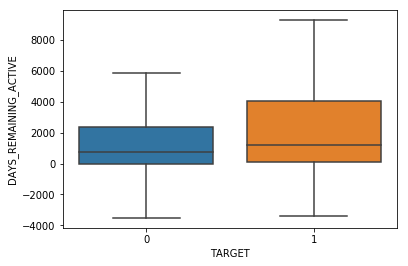

time: 139 ms


In [10]:
sns.boxplot(x="TARGET", 
           y="DAYS_REMAINING_ACTIVE", 
           data=df, 
           showfliers=False)

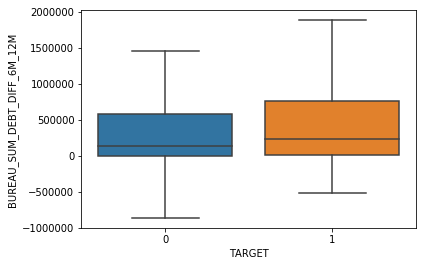

time: 124 ms


In [11]:
sns.boxplot(x="TARGET", 
           y="BUREAU_SUM_DEBT_DIFF_6M_12M", 
           data=df, 
           showfliers=False)

## Credit card

In [12]:
def credit_card_agg_func(g):
    mask6 = g["MONTHS_BALANCE"] >= -6
    mask12 = g["MONTHS_BALANCE"] >= -12
    mask24 = g["MONTHS_BALANCE"] >= -24
    
    d = {"MAX_CREDIT_CARD_SK_DPD_6M": np.nanmax(g["SK_DPD"].where(mask6)), 
        "MAX_CREDIT_CARD_SK_DPD_12M": np.nanmax(g["SK_DPD"].where(mask12)),
        "MAX_AMT_DRAWINGS_CURRENT_6M": np.nanmax(g["AMT_DRAWINGS_CURRENT"].where(mask6)), 
        "MAX_AMT_DRAWINGS_CURRENT_12M": np.nanmax(g["AMT_DRAWINGS_CURRENT"].where(mask12)), 
        "MAX_AMT_INST_MIN_REGULARITY_6M": np.nanmax(g["AMT_INST_MIN_REGULARITY"].where(mask6)), 
        "MAX_AMT_INST_MIN_REGULARITY_12M": np.nanmax(g["AMT_INST_MIN_REGULARITY"].where(mask12)), 
        "MAX_CNT_DRAWINGS_POS_CURRENT_6M": np.nanmax(g["CNT_DRAWINGS_POS_CURRENT"].where(mask6)), 
        "MAX_CNT_DRAWINGS_POS_CURRENT_12M": np.nanmax(g["CNT_DRAWINGS_POS_CURRENT"].where(mask12)), 
        "MAX_AMT_DRAWINGS_CURRENT_DIFF_12M_24M": np.nanmax(g["CNT_DRAWINGS_POS_CURRENT"].where(mask6)) - np.nanmax(g["CNT_DRAWINGS_POS_CURRENT"].where(mask12 ^ mask24)), 
        "SUM_CC_PAYMENT_DIFF_6M": np.nansum((g["AMT_PAYMENT_TOTAL_CURRENT"] - g["AMT_INST_MIN_REGULARITY"]).where(mask6)), 
        "SUM_CC_PAYMENT_DIFF_12M": np.nansum((g["AMT_PAYMENT_TOTAL_CURRENT"] - g["AMT_INST_MIN_REGULARITY"]).where(mask12))} 
    
    return pd.Series(d)

time: 68.9 ms


#### Process data and join

In [13]:
df = pd.read_csv(path + "application_train.csv")
df = df.sample(10000)

credit_card = pd.read_csv(path + "credit_card_balance.csv")
credit_card = credit_card[credit_card["SK_ID_CURR"].isin(df["SK_ID_CURR"])]
credit_card_agg = credit_card.groupby("SK_ID_CURR").apply(credit_card_agg_func).reset_index()
df = pd.merge(df, credit_card_agg, how="left", on="SK_ID_CURR")

time: 37.4 s


In [14]:
cols = ["MAX_CREDIT_CARD_SK_DPD_6M", 
        "MAX_CREDIT_CARD_SK_DPD_12M", 
        "MAX_AMT_DRAWINGS_CURRENT_6M", 
        "MAX_AMT_DRAWINGS_CURRENT_12M", 
        "MAX_AMT_INST_MIN_REGULARITY_6M", 
        "MAX_AMT_INST_MIN_REGULARITY_12M", 
        "MAX_CNT_DRAWINGS_POS_CURRENT_6M", 
        "MAX_CNT_DRAWINGS_POS_CURRENT_12M", 
        "MAX_AMT_DRAWINGS_CURRENT_DIFF_12M_24M", 
        "SUM_CC_PAYMENT_DIFF_6M", 
        "SUM_CC_PAYMENT_DIFF_12M"]

time: 1.9 ms


In [16]:
result = quick_model(X=df, 
           y=df["TARGET"], 
           usecols=cols, 
           n_estimators=1000, 
           num_leaves=23)

time: 20.4 s


In [17]:
result["auc"]

0.4855

time: 2.56 ms


In [18]:
result["var_imp"].head(20)

,Feature,Importance
10,SUM_CC_PAYMENT_DIFF_12M,4459
3,MAX_AMT_DRAWINGS_CURRENT_12M,3538
9,SUM_CC_PAYMENT_DIFF_6M,3409
2,MAX_AMT_DRAWINGS_CURRENT_6M,2437
5,MAX_AMT_INST_MIN_REGULARITY_12M,1806
8,MAX_AMT_DRAWINGS_CURRENT_DIFF_12M_24M,1687
4,MAX_AMT_INST_MIN_REGULARITY_6M,1656
7,MAX_CNT_DRAWINGS_POS_CURRENT_12M,1063
6,MAX_CNT_DRAWINGS_POS_CURRENT_6M,889
1,MAX_CREDIT_CARD_SK_DPD_12M,725


time: 7.12 ms


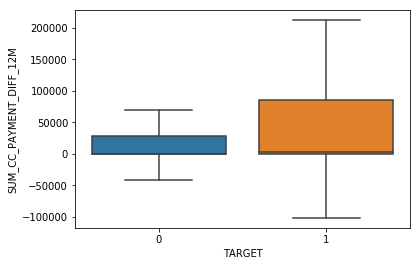

time: 114 ms


In [19]:
sns.boxplot(x="TARGET", 
           y="SUM_CC_PAYMENT_DIFF_12M", 
           data=df, 
           showfliers=False)

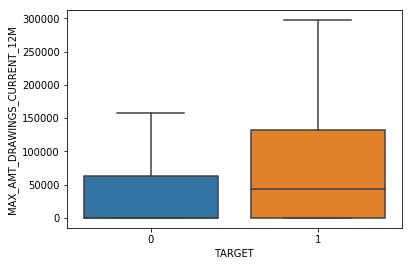

time: 120 ms


In [20]:
sns.boxplot(x="TARGET", 
           y="MAX_AMT_DRAWINGS_CURRENT_12M", 
           data=df, 
           showfliers=False)